## Modeling an industrializable semantic image segmentation model

In [1]:
import sys  
sys.path.insert(0, './scripts')

# Import librairies, configs, helper functions
from helpers import *
config = base_config
config["width"] = 512
config["height"] = 256
config["mlwflow_experiment_title"] = "UNET VGG16 Full size - Augmented"
config["use_saved_model_path"] = "./model_best.keras"

n = NotebookProcessor(config)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


{
    "width": 512,
    "height": 256,
    "classes": 8,
    "use_augment": true,
    "image_per_augment": 1,
    "max_evals": 1,
    "mlwflow_tracking_uri": "http://127.0.0.1:5000",
    "mlwflow_experiment_title": "UNET VGG16 Full size - Augmented",
    "train_sample_nb": 0,
    "val_sample_nb": 0,
    "use_saved_model_path": "./model_best.keras",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip
- Using the full training dataset
- Using the full validation dataset


## 1. Data preparation and exploration

Looking at the data structure:

`gtFine` and `leftImg8bit` folders both have the folders:  
- test
- train
- val

Within each of this folder is another list of folders of specific city.

The `leftImg8bit` contains raw image about the city.  
The `gtFine` contains three 4 informations about each raw image:
- color.png
- instanceIds.png
- labelsIds.png
- polygons.json

The first thing I'm going to do is to create a dataframe that will combine all of this data to be processed easily.  
And I will have **three** dataframe. `Train`, `Val` and `Test`.

### 1.1 Images to dataframe

In [2]:
n.dfs["train"].head()

,original_img_path,color_img_path,instance_ids_img_path,label_ids_img_path,polygons_json_path
0,./data/leftImg8bit/train/zurich/zurich_000101_...,./data/gtFine/train/zurich/zurich_000101_00001...,./data/gtFine/train/zurich/zurich_000101_00001...,./data/gtFine/train/zurich/zurich_000101_00001...,./data/gtFine/train/zurich/zurich_000101_00001...
1,./data/leftImg8bit/train/zurich/zurich_000098_...,./data/gtFine/train/zurich/zurich_000098_00001...,./data/gtFine/train/zurich/zurich_000098_00001...,./data/gtFine/train/zurich/zurich_000098_00001...,./data/gtFine/train/zurich/zurich_000098_00001...
2,./data/leftImg8bit/train/zurich/zurich_000078_...,./data/gtFine/train/zurich/zurich_000078_00001...,./data/gtFine/train/zurich/zurich_000078_00001...,./data/gtFine/train/zurich/zurich_000078_00001...,./data/gtFine/train/zurich/zurich_000078_00001...
3,./data/leftImg8bit/train/zurich/zurich_000016_...,./data/gtFine/train/zurich/zurich_000016_00001...,./data/gtFine/train/zurich/zurich_000016_00001...,./data/gtFine/train/zurich/zurich_000016_00001...,./data/gtFine/train/zurich/zurich_000016_00001...
4,./data/leftImg8bit/train/zurich/zurich_000051_...,./data/gtFine/train/zurich/zurich_000051_00001...,./data/gtFine/train/zurich/zurich_000051_00001...,./data/gtFine/train/zurich/zurich_000051_00001...,./data/gtFine/train/zurich/zurich_000051_00001...


### 1.2 What data do I need ?

I have multiple files that can be used to train my model.  
I'm not sure which one do I need.

Let's have a look at them first.

In [3]:
def display_images(row):  
    # Get the paths of the images from the DataFrame  
    original_img_path = row['original_img_path']  
    color_img_path = row['color_img_path']  
    instance_ids_img_path = row['instance_ids_img_path']  
    label_ids_img_path = row['label_ids_img_path']  
  
    # Open the images using PIL  
    original_img = Image.open(original_img_path)  
    color_img = Image.open(color_img_path)  
    instance_ids_img = Image.open(instance_ids_img_path)  
    label_ids_img = Image.open(label_ids_img_path)  
  
    # Create a figure with subplots  
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))  
  
    # Display the images in the subplots  
    ax[0].imshow(original_img)  
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  
  
    ax[1].imshow(color_img)  
    ax[1].set_title('Color Image')  
    ax[1].axis('off')  
  
    ax[2].imshow(instance_ids_img)  
    ax[2].set_title('Instance IDs Image')  
    ax[2].axis('off')  
  
    ax[3].imshow(label_ids_img)  
    ax[3].set_title('Label IDs Image')  
    ax[3].axis('off')  
  
    plt.show()  

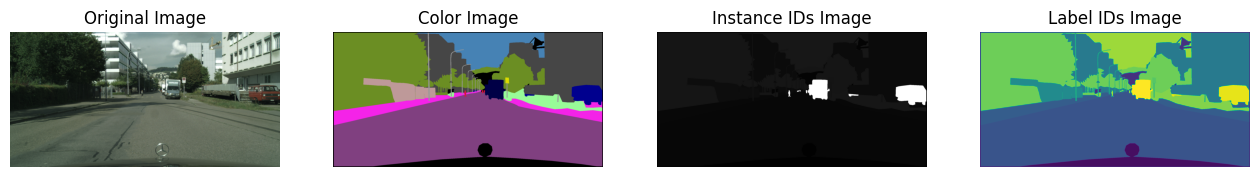

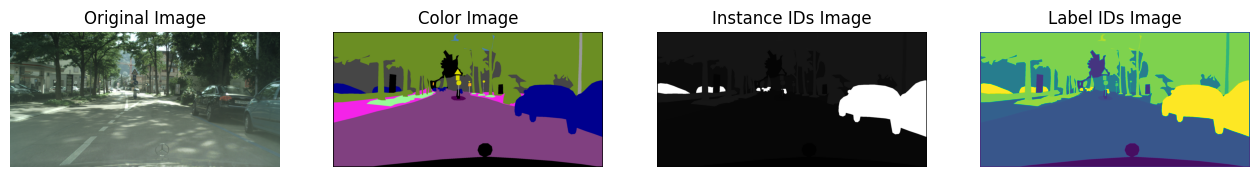

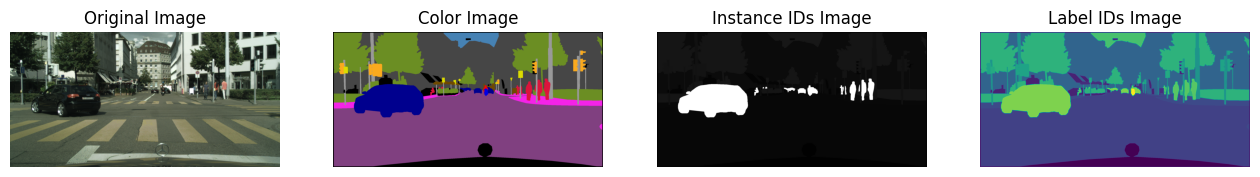

In [4]:
display_images(n.dfs["train"].loc[0])  
display_images(n.dfs["train"].loc[1])  
display_images(n.dfs["train"].loc[2])  

From that result, I will definitely use the original image.  
- The `color image` seems to have all the values as well as the `label ids image`
- The `instance ids image` seems to do it too using very similar shade of black and white. Making it difficult for our eyes to see the difference.

To be honest, the requirements is to train on only 8 categories and not the 32 sub categories.  
Here I have all of them but I don't know which one is which.

This is where the polygons_json_path seems interesting because it has all the labels and the polygons defined.  
I'm more confortable and confident to start using this approach. I know which labels correspond to what and I can use the polygons as the mask.

### 1.3 Polygons processing

To validate this approach, I am going to create the mask out of the polygons and see if it's correct.  
So I'm also going to map the subcategories to the 8 ones.

What are all the labels available in my polygons?

40 labels found


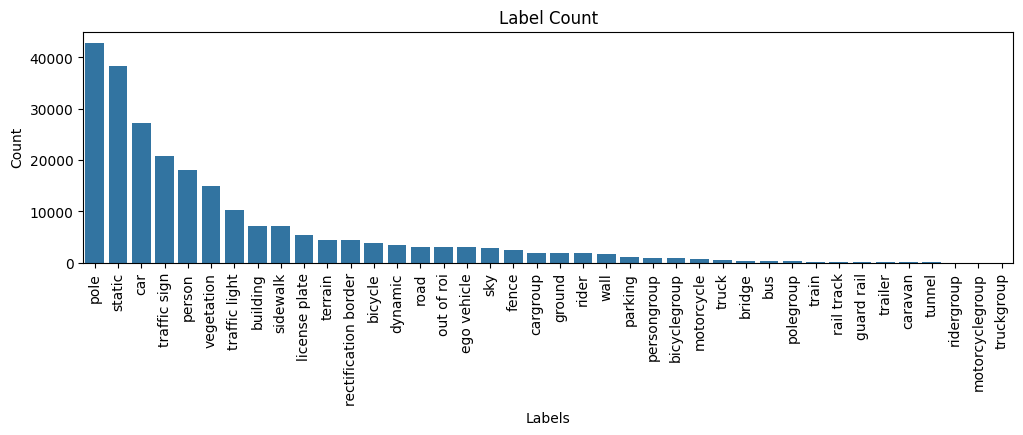

In [5]:
def polygon_labels(json_path):  
    # Load the JSON File 
    label_count = {}
    json_data = json.load(open(json_path))
    for obj in json_data['objects']:    
        label = obj['label']  
          
        # Check if label already exists in dictionary  
        if label in label_count:  
            label_count[label] += 1  # Increment count if label exists  
        else:  
            label_count[label] = 1  # Add new label to dictionary  
      
    return label_count

# Initialize dictionary to store label count
label_counts = n.dfs["train"]["polygons_json_path"].parallel_apply(polygon_labels)

# Combine all dictionaries  
combined_label_counts = {}  
for label_count in label_counts:  
    for label, count in label_count.items():  
        if label in combined_label_counts:  
            combined_label_counts[label] += count  
        else:  
            combined_label_counts[label] = count  
  
# Convert dictionary to a pandas DataFrame  
df_label_count = pd.DataFrame.from_dict(combined_label_counts, orient='index', columns=['count'])  
df_label_count = df_label_count.reset_index().rename(columns={'index': 'label'})  
  
# Sort the DataFrame by count in descending order  
df_label_count = df_label_count.sort_values('count', ascending=False)  

print(f"{len(combined_label_counts)} labels found")
  
# Plot the label count using seaborn  
plt.figure(figsize=(12, 3))
sns.barplot(x='label', y='count', data=df_label_count)  
plt.title("Label Count")  
plt.xlabel("Labels")  
plt.ylabel("Count")  
plt.xticks(rotation=90)  
plt.show()

Even better, 40 categories out of 32 expected, meaning I can be more flexible if needed.

From the dataset documentation:

> * Single instance annotations are available. However, if the boundary between such instances cannot be clearly seen, the whole crowd/group is labeled together and annotated as group, e.g. car group.
> + This label is not included in any evaluation and treated as void (or in the case of license plate as the vehicle mounted on).

Now let's do the mapping

In [6]:

def display_images_with_mask(row):  
    # Get the paths of the images from the DataFrame  
    original_img_path = row['original_img_path']  
    color_img_path = row['color_img_path']  
    label_ids_img_path = row['label_ids_img_path']
    # Open the images using PIL  
    original_img = Image.open(original_img_path)  
    color_img = Image.open(color_img_path)  
    mask_img = polygon_to_mask_img(row["polygons_json_path"])
    label_ids_img = Image.open(label_ids_img_path)  
  
    # Create a figure with subplots  
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))  
  
    # Display the images in the subplots  
    ax[0].imshow(original_img)  
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  
  
    ax[1].imshow(mask_img)  
    ax[1].set_title('Mask Image (8 cat)')  
    ax[1].axis('off')  
    
    ax[2].imshow(color_img)  
    ax[2].set_title('Color Image (32 cat)')  
    ax[2].axis('off')  
  
    ax[3].imshow(label_ids_img)  
    ax[3].set_title('Label IDs Image (32 cat)')  
    ax[3].axis('off')  
  
    plt.show()
    
    
def display_image_with_mask(row):
    
    original = Image.open(row['original_img_path']).convert("RGBA")  
    
    mask_img_array = polygon_to_mask_img(row["polygons_json_path"])
    color_map = plt.cm.get_cmap('viridis', 8)
    
    mask_img = color_map(mask_img_array)
    # mask_img = Image.fromarray(mask_img_array).convert("RGB")
    
    mask_with_opacity = mask_img.copy()
    overlay_with_opacity = mask_with_opacity.putalpha(int(255 * 0.5))
    
    blended_image = Image.alpha_composite(original, mask_with_opacity)  

    # Create a figure with subplots  
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))  
  
    # Display the images in the subplots  
    ax[0].imshow(original)  
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  
  

    ax[1].imshow(mask_img)  
    ax[1].set_title('Mask Image')  
    ax[1].axis('off')  
    
    ax[2].imshow(blended_image)  
    ax[2].set_title('Original + Mask')  
    ax[2].axis('off')
    plt.show()  

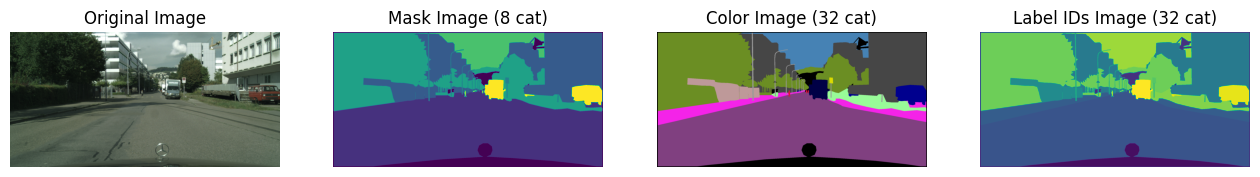

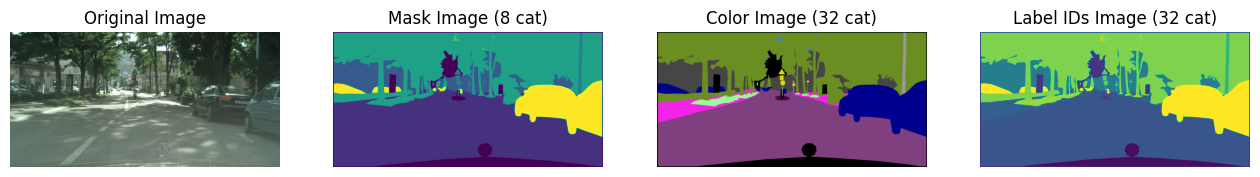

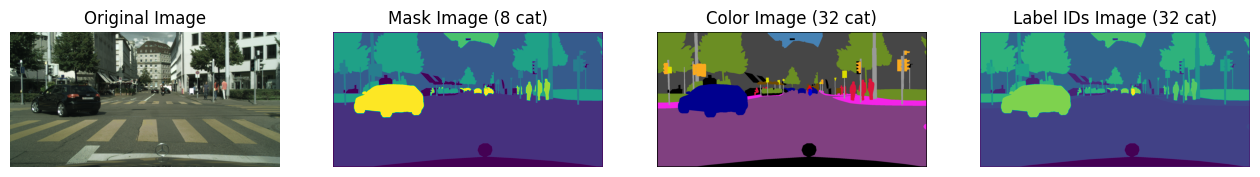

In [7]:
display_images_with_mask(n.dfs["train"].loc[0])  
display_images_with_mask(n.dfs["train"].loc[1])  
display_images_with_mask(n.dfs["train"].loc[2]) 

Great! Checking on three images, the polygon mask created **seems** to captures all the informations needed, and now we can define what it correspond to.
Let's put the mask on top of the original image:

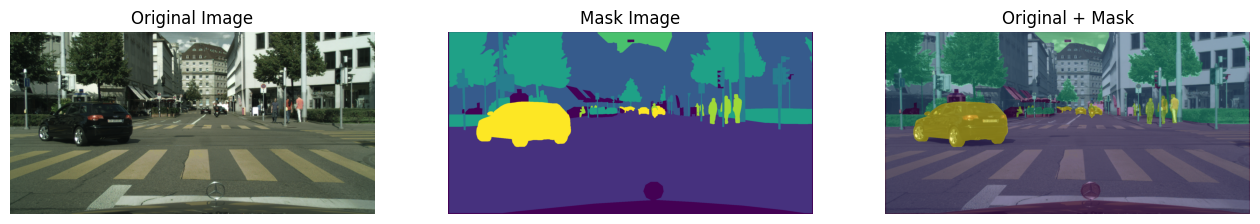

In [8]:
def display_image_with_mask(row):  
      
    original = Image.open(row['original_img_path']).convert("RGBA")  
      
    # Assuming polygon_to_mask_img returns a 2D array (mask)  
    mask_img_array = polygon_to_mask_img(row["polygons_json_path"])  
      
    # Apply colormap to mask and normalize the mask image array to be within the range [0, 1]  
    # before applying the colormap. Then, convert colormap output to uint8 (since colormap returns floats).  
    color_map = mpl.colormaps.get_cmap('viridis')  
        
    mask_img_array_normalized = mask_img_array / mask_img_array.max()  
    mask_img_colored = color_map(mask_img_array_normalized)  
    mask_img_colored = (mask_img_colored * 255).astype(np.uint8)  
      
    # Convert the RGBA numpy array to a PIL Image  
    mask_img = Image.fromarray(mask_img_colored, 'RGBA')  
      
    # Create a copy of the mask image to change its alpha.  
    # The putalpha method does not return a value; it modifies the image in place.  
    mask_with_opacity = mask_img.copy()  
    mask_with_opacity.putalpha(int(255 * 0.5))  
      
    # Ensure both original and mask_with_opacity images are in "RGBA" mode and have the same dimensions.  
    if original.size != mask_with_opacity.size:  
        mask_with_opacity = mask_with_opacity.resize(original.size)  
      
    blended_image = Image.alpha_composite(original, mask_with_opacity)  
      
    # Create a figure with subplots  
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))  
      
    # Display the images in the subplots  
    ax[0].imshow(original)  
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  
      
    ax[1].imshow(mask_img)  
    ax[1].set_title('Mask Image')  
    ax[1].axis('off')  
      
    ax[2].imshow(blended_image)  
    ax[2].set_title('Original + Mask')  
    ax[2].axis('off')  
      
    plt.show()  
    
    
display_image_with_mask(n.dfs["train"].loc[2])

At first, it seems perfect, but looking at the polygon difference vs the label ones, I can see a 0.33% difference on the full image size :  

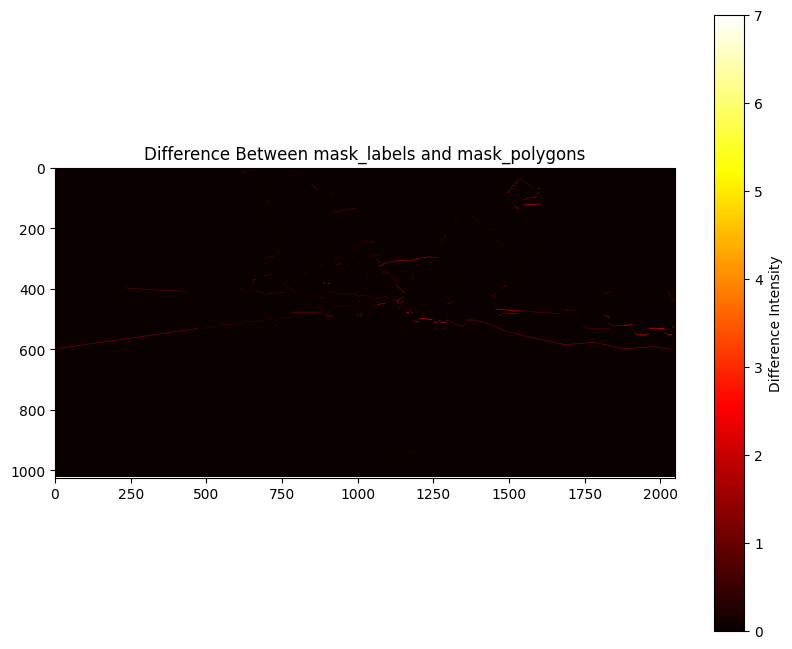

While it might not seems a lot, there's still a difference. And If I resized it, it's worst.  

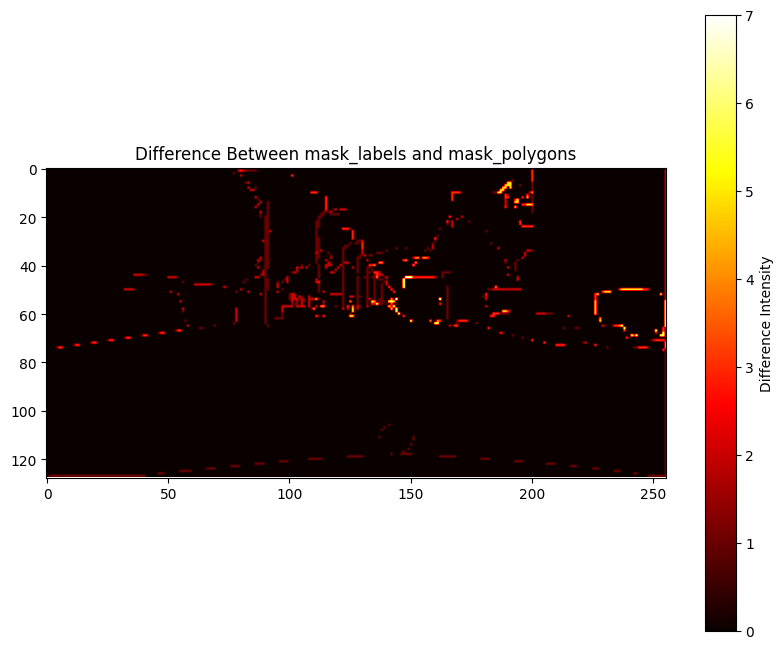


So at the end, I switch to use the label ids because it contains more information.

### 1.4 Image & Categories exploration

Let's quickly check if all images have the same width and height.  
Then we will see the distribution per category.

In [9]:
# Combining all dataframe for exploration
df_all = pd.concat([n.dfs["train"], n.dfs["val"], n.dfs["test"]]).reset_index(drop=True)
print(df_all.shape)

(3475, 5)


In [10]:
def get_image_size(image_path):  
    image = cv2.imread(image_path)  
    return f"{image.shape[1]}x{image.shape[0]}"  
  
def get_polygon_size(json_path):  
    json_data = json.load(open(json_path))
    return f"{json_data['imgWidth']}x{json_data['imgHeight']}"

def count_categories_in_polygon(json_path):
    categories = ["flat","human","vehicle","construction","object","nature", "sky", "void"]
    category_counts = {f"c_{k}": 0 for k in categories}  # Initialize counts  
    try: 
        data = json.load(open(json_path))
        for obj in data['objects']:
            label = obj['label']
            category = category_mapping.get(label)  # Map label to category  
            if category is not None:  
                category_counts[f"c_{categories[category-1]}"] += 1  # Increment count  
    except json.JSONDecodeError:  
        print("Error decoding JSON")  
    return category_counts  
 

In [11]:
# Apply the function to the "original_img_path" column  
df_all["img_size"] = df_all["original_img_path"].parallel_apply(get_image_size) 
df_all["mask_size"] = df_all["polygons_json_path"].parallel_apply(get_polygon_size)

In [12]:
print("Img unique size:", df_all["img_size"].nunique(), "=", df_all.loc[0]["img_size"])
print("Mask unique size:", df_all["mask_size"].nunique(), "=", df_all.loc[0]["mask_size"])

Img unique size: 1 = 2048x1024
Mask unique size: 1 = 2048x1024


All good, they all have the same size accross train, val, test.  
Let's now check the eight category distribution.

In [13]:
# Count category by image
counts_df = df_all['polygons_json_path'].parallel_apply(lambda x: count_categories_in_polygon(x))
counts_df = counts_df.parallel_apply(pd.Series)
df_all = pd.concat([df_all, counts_df], axis=1) 

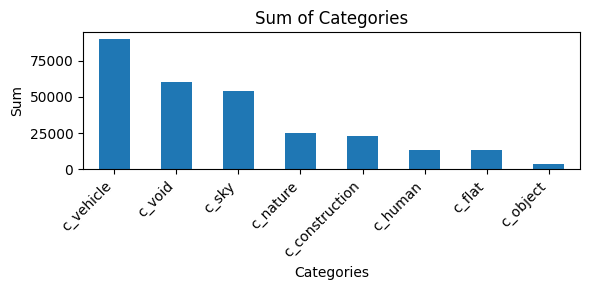

In [14]:

# Summing up the specified columns  
totals = df_all[["c_flat", "c_human", "c_vehicle",  
                        "c_construction", "c_object", "c_nature",   
                        "c_sky", "c_void"]].sum()
# Sorting totals from high to low  
totals = totals.sort_values(ascending=False)  
# Plotting  
plt.figure(figsize=(6, 3))
totals.plot(kind='bar')  
plt.title('Sum of Categories')  
plt.xlabel('Categories')  
plt.ylabel('Sum')  
plt.xticks(rotation=45, ha="right")
plt.tight_layout() 
plt.show()

Good to know, vehicle are the most present, follwoed by void and sky.  
Object being the smallest.

Let's create the final model!

## 2. Model development

Different approaches tested:
- Unet Mini
- Unet
- Unet with VGG16 pretrained
- Unet with VGG16 with image 224x224 pretrained

All of the approaches have been tested on:
- images of dimensions (512x256)
- 12 epochs
- with and without image augmentation

You can see all the details for each within the `scripts_modelisation_*` files.  
The most performant one is the `Unet with VGG16 pretrained`.

So I have ran different hyperparameters on this one.  
And the best one so far was the : `TODO_PUT_BEST_METRICS`.

So here I'm going to train it using the original image size.



In [15]:
def conv_block(input_tensor, num_filters, dropout_rate=0.1):  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    x = Dropout(dropout_rate)(x)  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    return x  
  
def create_model(n_classes, img_width, img_height, img_channels):    
    # Load VGG16 as the encoder with pretrained ImageNet weights  
    base_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, img_channels))  
      
    # Freeze the layers of VGG16  
    for layer in base_vgg16.layers:  
        layer.trainable = False  
      
    # Encoder - take the outputs of the VGG16 layers to create the contracting path  
    s1 = base_vgg16.get_layer("block1_conv2").output  # 64 filters  
    s2 = base_vgg16.get_layer("block2_conv2").output  # 128 filters  
    s3 = base_vgg16.get_layer("block3_conv3").output  # 256 filters  
    s4 = base_vgg16.get_layer("block4_conv3").output  # 512 filters  
    c5 = base_vgg16.get_layer("block5_conv3").output  # 512 filters, this acts as the bridge  
  
    # Start from bottom and go up, using U-Net's expansive path  
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)    
    u6 = concatenate([u6, s4])    
    c6 = conv_block(u6, 512)   
      
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)    
    u7 = concatenate([u7, s3])    
    c7 = conv_block(u7, 256)    
      
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)    
    u8 = concatenate([u8, s2])    
    c8 = conv_block(u8, 128)    
      
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)    
    u9 = concatenate([u9, s1])    
    c9 = conv_block(u9, 64)    
  
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)    
      
    model = Model(inputs=[base_vgg16.input], outputs=[outputs])  
      
    return model  

Here is an example of how the augmented image looks like

2024-03-05 00:01:53.762112: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-05 00:01:53.762142: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-03-05 00:01:53.762146: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-03-05 00:01:53.762177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-05 00:01:53.762194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


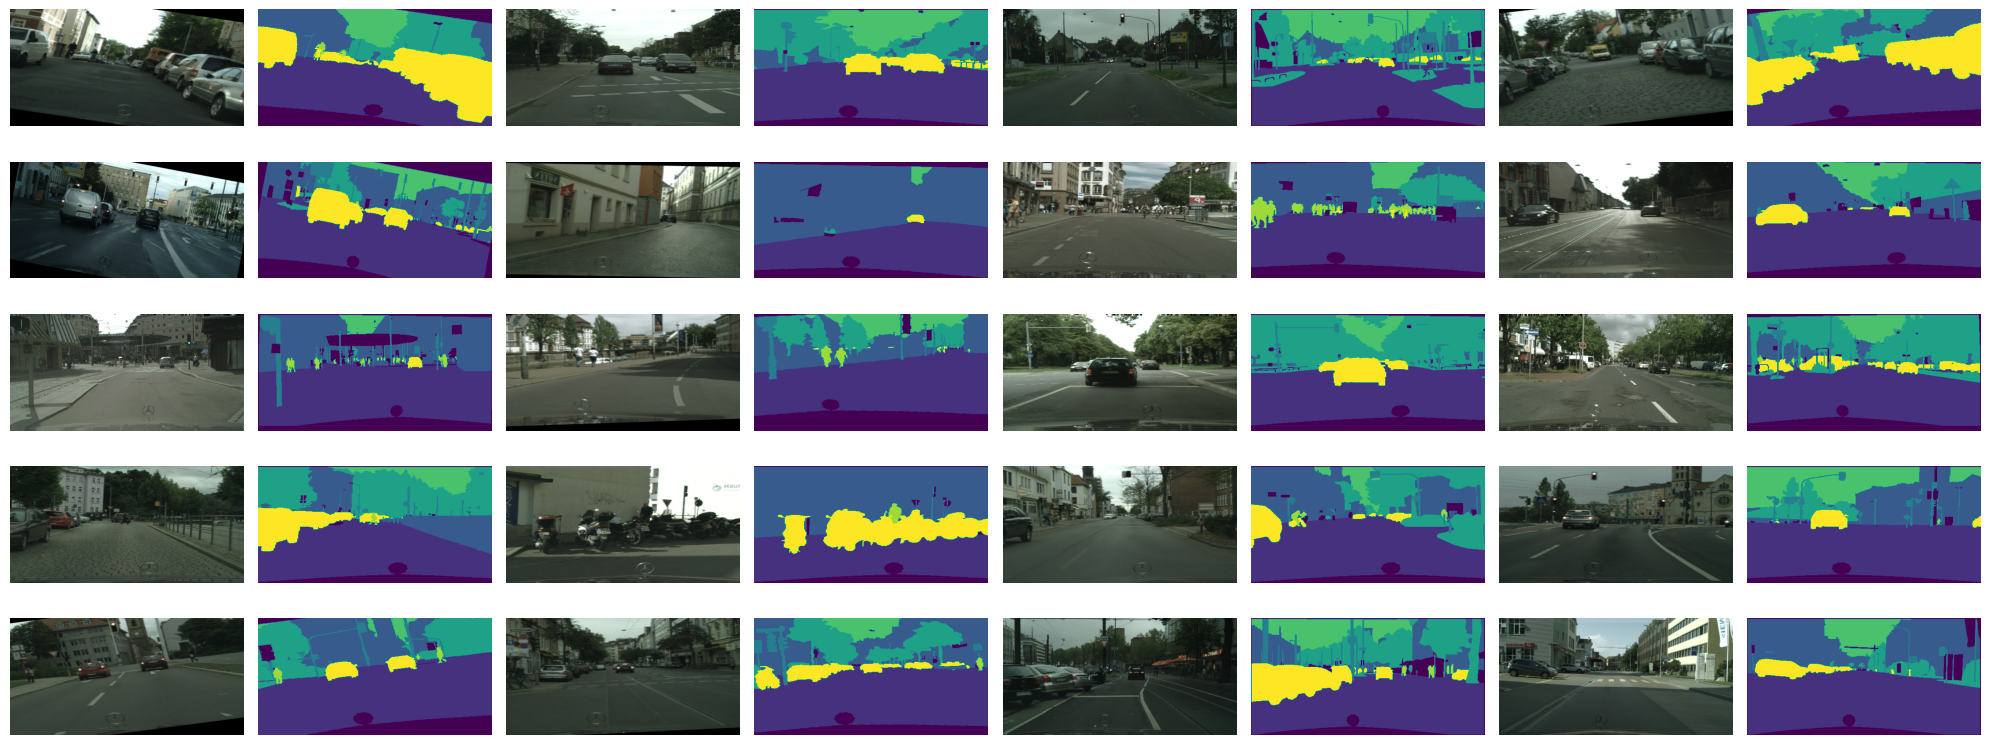

In [16]:
show_data_generator_images_sample(n)

In [17]:
model = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n.set_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 512, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 256, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

## 3. Model training

In [18]:
n.model_fit()

Skipping because of use_saved_model_path set in config
Loading model from config ./model_best.keras
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 512, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 256, 64)         0         ['block1_conv2[0][0]']   

## 4. Model evaluation

In [19]:
# display_loss_accuracy_dice_iou(n.model_fit_history)
n.model_predict_with_display_and_accuracy(n.img["test"][0],n.mask["test"][0])

AttributeError: 'NotebookProcessor' object has no attribute 'model_fit_history'

58/58 [==============================] - 21s 369ms/step - loss: 0.2263 - dice_coef: 0.8916 - iou: 0.8073 - accuracy: 0.9254


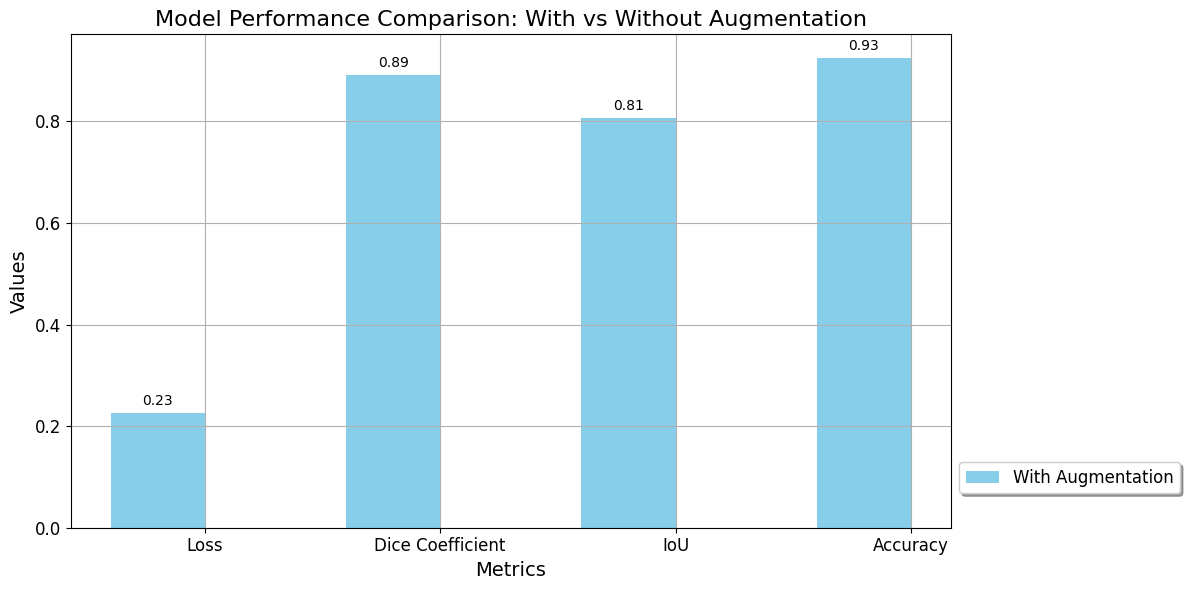

In [ ]:
evaluate_with_and_without_aug(n)